# Current Configurations 

* Language model Training on 28000+ wiki articles, Validating on ___ wiki articles
* vocabulary size : 10000, min_freq = 3
* Language Model finetuning on ____ imdb articles, 
* Classifier training on _____ imdb reviews , validation on ____ imdb reviews
* embedding size = 
* number of lstm units
* lstm layer number


### Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from tensorflow.python.ops import lookup_ops
from tensorflow.python.training.tracking import tracking


from absl import app
from absl import flags
import numpy as np
import tensorflow.compat.v2 as tf
import os
import tempfile
import re
import html 

In [2]:
print(tf.__version__)

2.0.0-beta1


In [3]:
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM,Input,Embedding
from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization, Dropout,GlobalMaxPooling1D,GlobalAveragePooling1D,concatenate


In [4]:
import pickle

In [5]:
from language_model import *

# Load IMDB Reviews 

In [6]:
with open('data/imdb_reviews.pkl', 'rb') as f:
    imdb_reviews = pickle.load(f)
    
with open('data/imdb_labels.pkl', 'rb') as f:
    imdb_labels = pickle.load(f)
    



# Load IMDB Validation Data

In [7]:
with open('data/imdb_valid_reviews.pkl', 'rb') as f:
    imdb_valid_reviews = pickle.load(f)
    
with open('data/imdb_valid_labels.pkl', 'rb') as f:
    imdb_valid_labels = pickle.load(f)
    



# IMDB Label Encoding 

In [8]:
imdb_labels = tf.keras.utils.to_categorical(imdb_labels,2)

In [9]:
imdb_valid_labels = tf.keras.utils.to_categorical(imdb_valid_labels,2)

# Make Tensorflow Datasets for Batching 

In [10]:
imdb_dataset = tf.data.Dataset.from_tensor_slices(imdb_reviews).batch(16,drop_remainder=True)

In [11]:
imdb_dataset_labels = tf.data.Dataset.from_tensor_slices(imdb_labels).batch(16,drop_remainder=True)

In [12]:
imdb_train_set = tf.data.Dataset.zip((imdb_dataset,imdb_dataset_labels))

# The Bug 

In [13]:
sentences = ["<S> hello there <E>", "<S> how are you doing today <E>","<S> I am fine thank you <E>",
             "<S> hello world <E>", "<S> who are you? <E>"]
validation_sentences = ["<S> hello there <E>", "<S> how are you doing today <E>","<S> I am fine thank you <E>"]
vocab = [
      "<S>", "<E>", "hello", "there", "how", "are", "you", "doing", "today","I","am","fine","thank","world","who"]

module = ULMFiTModule(vocab=vocab, emb_dim=10, buckets=1, state_size=128,n_layers=1)

for epoch in range(1):
    train_loss = module.train(tf.constant(sentences))
    validation_loss = module.validate(tf.constant(validation_sentences))
    print("Epoch ",epoch," Train loss: ",train_loss.numpy()," Validation loss ",validation_loss.numpy())

W0823 10:50:39.162348 140467105605376 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/lookup_ops.py:985: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch  0  Train loss:  2.771884  Validation loss  2.7692854


# Load Pretrained Module

In [14]:
module = tf.saved_model.load("finetuned_language_model")

# Classifier Head 


Classifier head takes in the final layer output of the languaage model and first gets the average pool and max pool of the 
final layer outputs, then passes the concatanation of last time steps hidden state, max pool results and average pool results through given number Dense-dropout-batchnormalization blocks. Finally it produces the classifier output probabilities.

In [15]:
class LanguageClassifier(Model):
    def __init__(self,language_module,num_labels,dense_units=(128,128),dropouts=(0.1,0.1)):
        
        # initialization stuff
        super(LanguageClassifier,self).__init__()
        self._language_module = language_module
        self.model_encoder = language_module.model
        
        
        # classifier head layers
        self.dense_layers = [Dense(units,activation="relu") for units in dense_units]
        self.dropout_layers = [Dropout(p) for p in dropouts]
        self.max_pool_layer = GlobalMaxPooling1D()
        self.average_pool_layer = GlobalAveragePooling1D()
        self.batchnorm_layer = BatchNormalization()
        self.n_layers = len(self.dense_layers)
        self.final_layer = Dense(num_labels,activation="sigmoid")
        
    def __call__(self,sentences):
        
        tokens,lookup_ids = self._language_module._tokens_to_lookup_ids(sentences)
        self.enc_out = self.model_encoder(lookup_ids)
        last_h = self.enc_out[:,-1,:]
        max_pool_output = self.max_pool_layer(self.enc_out)
        average_pool_output = self.average_pool_layer(self.enc_out)
        
        output = concatenate([last_h,max_pool_output,average_pool_output])
        
        for i in range(self.n_layers):
            output = self.dense_layers[i](output)
            #output = self.dropout_layers[i](output)
            output = self.batchnorm_layer(output)
        
        final_output = self.final_layer(output)
        return final_output        

In [16]:
model = LanguageClassifier(language_module=module,num_labels=2)

# Classifier Training 

In [18]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [19]:
train_loss_hist = []
train_accuracy_hist = []

def track(tl_score,tl_accuracy):
    train_loss_hist.append(tl_score)
    train_accuracy_hist.append(tl_accuracy)

@tf.function
def train_step(samples, labels):
  with tf.GradientTape() as tape:
    predictions = model(samples)
    loss = loss_object(labels, predictions)
  watched = tape.watched_variables()
  gradients = tape.gradient(loss, watched)
  optimizer.apply_gradients(zip(gradients, watched))

  train_loss(loss)
  train_accuracy(labels, predictions)
  return loss, train_accuracy(labels,predictions)
    
    
@tf.function
def test_step(samples, labels):
  predictions = model(samples)
  t_loss = loss_object(labels, predictions)
  test_loss(t_loss)
  test_accuracy(labels, predictions)


In [ ]:
EPOCHS = 2
step = 0
for epoch in range(EPOCHS):
    for reviews,labels in imdb_train_set:
        loss,acc = train_step(reviews, labels)
        track(loss,acc)
        if step%500==0:
            print("Step ",step, " loss ",loss," Accuracy ", acc.numpy()*100)
        step+=1

Step  0  loss  tf.Tensor(0.677494, shape=(), dtype=float32)  Accuracy  56.25


# Reflection 

The classifier was not trained, but I couldn't get the gains I was supposed to get by starting from finetuned language model. Language model loss was around 4.9 after finetuning on Imdb, but I'm probably updating the gradients at a higher learning rate than needed. Original ULMFiT uses a highly regularized AWD-LSTM model while this one is a vanilla LSTM network. And also during finetuning I should probably be reducing the learning rate and do gradual unfreezing of layers , in the current implementation the classifier is losing the knowledge gained during language model training because of larger learning rate. More experiments with smaller learning rates will also be beneficial. Comparing how long this model takes to converge after being started from random weights vs finetuned weights will also be beneficial.

# Language Model Training Loss

In [6]:
with open('train_losses.pkl', 'rb') as f:
    train_losses = pickle.load(f)

In [7]:
losses = [l.numpy() for l in train_losses]

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
losses = pd.Series(losses)

In [14]:
train_los = []
for i,v in enumerate(losses):
    if i%500==0:
        train_los.append(v)

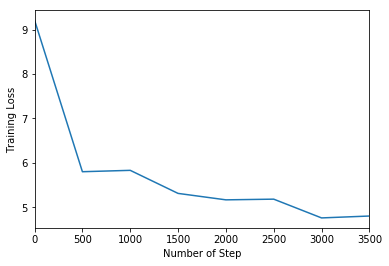

In [28]:
ax = pd.Series(train_los).plot()
plt.xlabel("Number of Step")
plt.ylabel("Training Loss")
ax.set_xticklabels(labels=['0','500','1000','1500','2000','2500','3000','3500']);